In [0]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import resnet18

from PIL import Image
from tqdm import tqdm

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision.datasets import VisionDataset

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image




def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        #self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        self.root = root
 
        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''
        z=0
        c=0
        
        dir = os.path.expanduser(root+'101_ObjectCategories/')
        l=[]
        self.samples=[]
        labels=[]
        n=[]
        
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]        
        classes.sort()
        print(len(classes),classes)
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        del class_to_idx['BACKGROUND_Google']
        print(len(class_to_idx),class_to_idx)
        b = 0
        with open(root + split+'.txt','r') as f:
            for line in f:
                row = line.split("\n")[0]
                #empty = field[1]
                label = line.split("/")[0]
                if(label != 'BACKGROUND_Google'):
                    self.path = os.path.join(dir,row)
                    s = class_to_idx[label]
                    self.n=n
                    self.n.append(s)
                    self.samples.append((pil_loader(self.path),s))
                    c = c+1
                z+=1
        
        
        

        dim = self.__len__()
        f.close()
        
        print("iterations without BACKGROUND",c)
        print("iterations with BACKGROUND",z)
       
        print("Number of images of %s = %d "%(split, dim))
        print("Number of images of %s without BACKGROUND_Google Class = %d" %(split,c))      
        print("len",len(class_to_idx))


    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''   
        #image, label =  
                           # Provide a way to access image and label via index
                           # Image should be a PIL Image
                           # label can be int

        image,label = self.samples[index]        #print("index",index)
        #print("label",label)
        #image,label = self.path,index
        #image = pil_loader(self.path)
        #image = pil_loader(path)

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)
            #print(image)
            #label=self.transform(label)
        if label>4048:
            label-=4048
        return image, label-1

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        print(len(self.n))
         # Provide a way to get the length (number of elements) of the dataset
        return len(self.n)



In [0]:
#SET ARGUMENTS
DEVICE = 'cuda' # 'cuda' or 'cpu'


NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 64  # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3          # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS =  40   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [0]:
#PREPARE DATA PREPROCESSING
# Define transforms for training phase
#randogreysclae + orizontal flif
#centre crop+randomgrey+orizontalflip
#centercrop+randomorizontalflip
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),
                                       #transforms.RandomGrayscale(p=0.5),
                                      
                                           # Crops a central square patch of the image
                                       transforms.RandomHorizontalFlip(),                            # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                       
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
                                      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

In [17]:
#PREPARE DATASET
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
    !git clone https://github.com/sofiaborgato/Homework2-Caltech101.git
    os.rename('Homework2-Caltech101','Caltech101')

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    


DATA_DIR = 'Caltech101/'
from torchvision.datasets import VisionDataset
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
first_train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
print(first_train_dataset.__len__())

test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_indexes = [i for i in range(len(first_train_dataset)) if i % 2]
print(train_indexes)
val_indexes = [i for i in range(len(first_train_dataset)) if not i % 2]
print(val_indexes)
train_dataset = Subset(first_train_dataset, train_indexes)
val_dataset = Subset(first_train_dataset, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

102 ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy'

In [0]:
#PREPARE DATALOADERS
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset,batch_size=int(BATCH_SIZE), shuffle=False, num_workers=4)


test_dataloader = DataLoader(test_dataset,batch_size=int(BATCH_SIZE), shuffle=False, num_workers=4)

In [0]:
#PREPARE NETWORK
#net = alexnet(pretrained=True, progress=True) # Loading AlexNet model
net = resnet18(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, NUM_CLASSES)
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
#freeze part of the net FC or CV
#for i,(name, param) in  enumerate(net.named_parameters()):
  #print(i, name)
  #if i <10:
    #param.requires_grad = False
# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

In [0]:
#PREPARE TRAINING 

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer =optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [22]:
#TRAIN WITH VALIDATION

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark = True # Calling this optimizes runtime
#Hyper-parameter to optimize
learning_rate_vector=[1e-2,1e-3]
epoch_vector=[50,30]
loss_val=[]

acc_train=[]
current_step = 0
best_accuracy = 0
loss_vector = []
tot_accuracy = []

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  running_correct_train=0
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)
    #calculte accuracy also on train set
    _, preds = torch.max(outputs.data, 1)
    running_correct_train += torch.sum(preds == labels.data).data.item()
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  loss_vector.append(loss.item())
  acc_t=running_correct_train / float(len(val_dataset))
  acc_train.append(acc_t)
  # Step the scheduler
  scheduler.step()

  #VALIDATION
  net.train(False) # Set Network to evaluation mode
  

  running_corrects = 0
  with torch.no_grad():
      for images, labels in tqdm(val_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))
  #loss on validation
  loss_val.append(criterion(outputs,labels))
  tot_accuracy.append(accuracy)
  print('Validation Accuracy: {}'.format(accuracy))

  if accuracy>best_accuracy:
    best_net = copy.deepcopy(net)
    best_accuracy=accuracy



    

Starting epoch 1/40, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.885072231292725
Step 10, Loss 4.494211196899414
Step 20, Loss 4.0288615226745605
Step 30, Loss 3.3324689865112305
Step 40, Loss 3.226593017578125


100%|██████████| 46/46 [00:06<00:00,  6.66it/s]

Validation Accuracy: 0.355463347164592
Starting epoch 2/40, LR = [0.001]


Step 50, Loss 3.0213983058929443
Step 60, Loss 2.7256693840026855
Step 70, Loss 2.752765417098999
Step 80, Loss 2.3124804496765137


100%|██████████| 46/46 [00:06<00:00,  6.75it/s]

Validation Accuracy: 0.5428769017980636
Starting epoch 3/40, LR = [0.001]


Step 90, Loss 2.2811880111694336
Step 100, Loss 2.1665573120117188
Step 110, Loss 2.029799222946167
Step 120, Loss 1.827233910560608
Step 130, Loss 2.0135626792907715


100%|██████████| 46/46 [00:06<00:00,  6.78it/s]

Validation Accuracy: 0.6535269709543569
Starting epoch 4/40, LR = [0.001]


Step 140, Loss 2.1424522399902344
Step 150, Loss 1.8543853759765625
Step 160, Loss 1.573302149772644
Step 170, Loss 1.605384349822998


100%|██████████| 46/46 [00:06<00:00,  6.78it/s]

Validation Accuracy: 0.7233748271092669
Starting epoch 5/40, LR = [0.001]


Step 180, Loss 1.588622808456421
Step 190, Loss 1.4342916011810303
Step 200, Loss 1.171217918395996
Step 210, Loss 1.6353083848953247
Step 220, Loss 1.0096230506896973


100%|██████████| 46/46 [00:06<00:00,  6.78it/s]

Validation Accuracy: 0.7728215767634855
Starting epoch 6/40, LR = [0.001]


Step 230, Loss 1.1593669652938843
Step 240, Loss 1.063490390777588
Step 250, Loss 1.080433964729309
Step 260, Loss 1.04444420337677


100%|██████████| 46/46 [00:06<00:00,  6.76it/s]

Validation Accuracy: 0.8091286307053942
Starting epoch 7/40, LR = [0.001]


Step 270, Loss 0.7250773906707764
Step 280, Loss 1.0603543519973755
Step 290, Loss 0.7689027190208435
Step 300, Loss 0.8207598328590393
Step 310, Loss 0.7957533597946167


100%|██████████| 46/46 [00:06<00:00,  6.68it/s]

Validation Accuracy: 0.8371369294605809
Starting epoch 8/40, LR = [0.001]


Step 320, Loss 0.823460042476654
Step 330, Loss 0.7057192325592041
Step 340, Loss 0.8130701780319214
Step 350, Loss 0.8718681335449219


100%|██████████| 46/46 [00:06<00:00,  6.77it/s]

Validation Accuracy: 0.863762102351314
Starting epoch 9/40, LR = [0.001]


Step 360, Loss 0.590836763381958
Step 370, Loss 0.5826101899147034
Step 380, Loss 0.658867359161377
Step 390, Loss 0.7948847413063049
Step 400, Loss 0.42763590812683105


100%|██████████| 46/46 [00:06<00:00,  6.77it/s]

Validation Accuracy: 0.8782849239280774
Starting epoch 10/40, LR = [0.001]


Step 410, Loss 0.5970062017440796
Step 420, Loss 0.34617945551872253
Step 430, Loss 0.48995497822761536
Step 440, Loss 0.6616495847702026


100%|██████████| 46/46 [00:06<00:00,  6.83it/s]

Validation Accuracy: 0.8893499308437067
Starting epoch 11/40, LR = [0.001]


Step 450, Loss 0.5318638682365417
Step 460, Loss 0.39514270424842834
Step 470, Loss 0.5205066800117493
Step 480, Loss 0.3507852852344513
Step 490, Loss 0.45291662216186523


100%|██████████| 46/46 [00:06<00:00,  6.77it/s]

Validation Accuracy: 0.9007607192254495
Starting epoch 12/40, LR = [0.001]


Step 500, Loss 0.32126671075820923
Step 510, Loss 0.4723895788192749
Step 520, Loss 0.28449851274490356
Step 530, Loss 0.293173223733902


100%|██████████| 46/46 [00:06<00:00,  6.79it/s]

Validation Accuracy: 0.9066390041493776
Starting epoch 13/40, LR = [0.001]


Step 540, Loss 0.3728376030921936
Step 550, Loss 0.28726503252983093
Step 560, Loss 0.2102353274822235
Step 570, Loss 0.3370180130004883
Step 580, Loss 0.4019213318824768


100%|██████████| 46/46 [00:06<00:00,  6.67it/s]

Validation Accuracy: 0.9090594744121715
Starting epoch 14/40, LR = [0.001]


Step 590, Loss 0.32038554549217224
Step 600, Loss 0.3116820454597473
Step 610, Loss 0.2024969756603241
Step 620, Loss 0.4142577648162842


100%|██████████| 46/46 [00:06<00:00,  6.73it/s]

Validation Accuracy: 0.906984785615491
Starting epoch 15/40, LR = [0.001]


Step 630, Loss 0.21632103621959686
Step 640, Loss 0.27436766028404236
Step 650, Loss 0.17236633598804474
Step 660, Loss 0.2844655513763428
Step 670, Loss 0.20106202363967896


100%|██████████| 46/46 [00:06<00:00,  6.73it/s]

Validation Accuracy: 0.9125172890733056
Starting epoch 16/40, LR = [1e-05]


Step 680, Loss 0.2157583087682724
Step 690, Loss 0.18187789618968964
Step 700, Loss 0.2008354514837265
Step 710, Loss 0.17391681671142578


100%|██████████| 46/46 [00:06<00:00,  6.74it/s]

Validation Accuracy: 0.9159751037344398
Starting epoch 17/40, LR = [0.0001]


Step 720, Loss 0.15365922451019287
Step 730, Loss 0.12136784940958023
Step 740, Loss 0.27703362703323364
Step 750, Loss 0.20794087648391724
Step 760, Loss 0.1503419280052185


100%|██████████| 46/46 [00:06<00:00,  6.77it/s]

Validation Accuracy: 0.9132088520055325
Starting epoch 18/40, LR = [0.0001]


Step 770, Loss 0.2558332085609436
Step 780, Loss 0.20479366183280945
Step 790, Loss 0.1890784204006195
Step 800, Loss 0.16241015493869781


100%|██████████| 46/46 [00:06<00:00,  6.74it/s]

Validation Accuracy: 0.9187413554633471
Starting epoch 19/40, LR = [0.0001]


Step 810, Loss 0.16716960072517395
Step 820, Loss 0.20546016097068787
Step 830, Loss 0.203340083360672
Step 840, Loss 0.24888485670089722
Step 850, Loss 0.196309894323349


100%|██████████| 46/46 [00:06<00:00,  6.67it/s]

Validation Accuracy: 0.9156293222683264
Starting epoch 20/40, LR = [0.0001]


Step 860, Loss 0.1999715119600296
Step 870, Loss 0.17193925380706787
Step 880, Loss 0.1852407455444336
Step 890, Loss 0.16561254858970642


100%|██████████| 46/46 [00:06<00:00,  6.70it/s]

Validation Accuracy: 0.9107883817427386
Starting epoch 21/40, LR = [0.0001]


Step 900, Loss 0.15487922728061676
Step 910, Loss 0.20617038011550903
Step 920, Loss 0.25610655546188354
Step 930, Loss 0.21456845104694366
Step 940, Loss 0.24889126420021057


100%|██████████| 46/46 [00:06<00:00,  6.83it/s]

Validation Accuracy: 0.9163208852005532
Starting epoch 22/40, LR = [0.0001]


Step 950, Loss 0.22153587639331818
Step 960, Loss 0.23549214005470276
Step 970, Loss 0.1285061240196228
Step 980, Loss 0.19905361533164978


100%|██████████| 46/46 [00:06<00:00,  6.76it/s]

Validation Accuracy: 0.9163208852005532
Starting epoch 23/40, LR = [0.0001]


Step 990, Loss 0.1683748960494995
Step 1000, Loss 0.2071472704410553
Step 1010, Loss 0.26408058404922485
Step 1020, Loss 0.2052934318780899
Step 1030, Loss 0.208608478307724


100%|██████████| 46/46 [00:06<00:00,  6.69it/s]

Validation Accuracy: 0.9156293222683264
Starting epoch 24/40, LR = [0.0001]


Step 1040, Loss 0.22749094665050507
Step 1050, Loss 0.2534593939781189
Step 1060, Loss 0.22154760360717773
Step 1070, Loss 0.2518784701824188


100%|██████████| 46/46 [00:06<00:00,  6.58it/s]

Validation Accuracy: 0.9215076071922544
Starting epoch 25/40, LR = [0.0001]


Step 1080, Loss 0.13431233167648315
Step 1090, Loss 0.14154675602912903
Step 1100, Loss 0.15682339668273926
Step 1110, Loss 0.22299236059188843
Step 1120, Loss 0.19161930680274963


100%|██████████| 46/46 [00:06<00:00,  6.73it/s]

Validation Accuracy: 0.9180497925311203
Starting epoch 26/40, LR = [0.0001]


Step 1130, Loss 0.2679389715194702
Step 1140, Loss 0.1914992332458496
Step 1150, Loss 0.1499735713005066
Step 1160, Loss 0.17064310610294342


100%|██████████| 46/46 [00:06<00:00,  6.74it/s]

Validation Accuracy: 0.9183955739972337
Starting epoch 27/40, LR = [0.0001]


Step 1170, Loss 0.17097380757331848
Step 1180, Loss 0.21174356341362
Step 1190, Loss 0.14478394389152527
Step 1200, Loss 0.18260981142520905
Step 1210, Loss 0.1991054266691208


100%|██████████| 46/46 [00:06<00:00,  6.77it/s]

Validation Accuracy: 0.9183955739972337
Starting epoch 28/40, LR = [0.0001]


Step 1220, Loss 0.18549436330795288
Step 1230, Loss 0.18332187831401825
Step 1240, Loss 0.2526213228702545
Step 1250, Loss 0.12446776032447815


100%|██████████| 46/46 [00:06<00:00,  6.73it/s]

Validation Accuracy: 0.9187413554633471
Starting epoch 29/40, LR = [0.0001]


Step 1260, Loss 0.14865347743034363
Step 1270, Loss 0.11200208961963654
Step 1280, Loss 0.21051523089408875
Step 1290, Loss 0.12541311979293823
Step 1300, Loss 0.2353353500366211


100%|██████████| 46/46 [00:06<00:00,  6.70it/s]

Validation Accuracy: 0.9180497925311203
Starting epoch 30/40, LR = [0.0001]


Step 1310, Loss 0.15062376856803894
Step 1320, Loss 0.18468499183654785
Step 1330, Loss 0.28890371322631836
Step 1340, Loss 0.2006342113018036


100%|██████████| 46/46 [00:06<00:00,  6.74it/s]

Validation Accuracy: 0.9201244813278008
Starting epoch 31/40, LR = [1.0000000000000002e-06]


Step 1350, Loss 0.14840304851531982
Step 1360, Loss 0.2013174295425415
Step 1370, Loss 0.15335071086883545
Step 1380, Loss 0.18044130504131317
Step 1390, Loss 0.17536436021327972


100%|██████████| 46/46 [00:06<00:00,  6.78it/s]

Validation Accuracy: 0.9183955739972337
Starting epoch 32/40, LR = [1e-05]


Step 1400, Loss 0.2448922097682953
Step 1410, Loss 0.15986260771751404
Step 1420, Loss 0.11633040755987167
Step 1430, Loss 0.18873606622219086


100%|██████████| 46/46 [00:06<00:00,  6.76it/s]

Validation Accuracy: 0.9139004149377593
Starting epoch 33/40, LR = [1e-05]


Step 1440, Loss 0.2136533558368683
Step 1450, Loss 0.18913023173809052
Step 1460, Loss 0.21721534430980682
Step 1470, Loss 0.17697356641292572
Step 1480, Loss 0.14996986091136932


100%|██████████| 46/46 [00:06<00:00,  6.77it/s]

Validation Accuracy: 0.9204702627939142
Starting epoch 34/40, LR = [1e-05]


Step 1490, Loss 0.18625910580158234
Step 1500, Loss 0.15503619611263275
Step 1510, Loss 0.2138267457485199
Step 1520, Loss 0.32311511039733887


100%|██████████| 46/46 [00:06<00:00,  6.78it/s]

Validation Accuracy: 0.919432918395574
Starting epoch 35/40, LR = [1e-05]


Step 1530, Loss 0.19205835461616516
Step 1540, Loss 0.12772993743419647
Step 1550, Loss 0.0877261757850647
Step 1560, Loss 0.18676605820655823
Step 1570, Loss 0.1902916133403778


100%|██████████| 46/46 [00:06<00:00,  6.65it/s]

Validation Accuracy: 0.9204702627939142
Starting epoch 36/40, LR = [1e-05]


Step 1580, Loss 0.12510082125663757
Step 1590, Loss 0.15230578184127808
Step 1600, Loss 0.07823944836854935
Step 1610, Loss 0.18352121114730835


100%|██████████| 46/46 [00:06<00:00,  6.80it/s]

Validation Accuracy: 0.9180497925311203
Starting epoch 37/40, LR = [1e-05]


Step 1620, Loss 0.24432197213172913
Step 1630, Loss 0.23046985268592834
Step 1640, Loss 0.14637517929077148
Step 1650, Loss 0.14481692016124725
Step 1660, Loss 0.21432152390480042


100%|██████████| 46/46 [00:06<00:00,  6.77it/s]

Validation Accuracy: 0.9204702627939142
Starting epoch 38/40, LR = [1e-05]


Step 1670, Loss 0.16403426229953766
Step 1680, Loss 0.24560925364494324
Step 1690, Loss 0.23617993295192719
Step 1700, Loss 0.2699328660964966


100%|██████████| 46/46 [00:06<00:00,  6.77it/s]

Validation Accuracy: 0.9201244813278008
Starting epoch 39/40, LR = [1e-05]


Step 1710, Loss 0.19909045100212097
Step 1720, Loss 0.15077191591262817
Step 1730, Loss 0.1641089916229248
Step 1740, Loss 0.1967100203037262
Step 1750, Loss 0.1266046166419983


100%|██████████| 46/46 [00:06<00:00,  6.76it/s]

Validation Accuracy: 0.9173582295988935
Starting epoch 40/40, LR = [1e-05]


Step 1760, Loss 0.14697642624378204
Step 1770, Loss 0.20869123935699463
Step 1780, Loss 0.15681621432304382
Step 1790, Loss 0.1779930293560028


100%|██████████| 46/46 [00:06<00:00,  6.71it/s]

Validation Accuracy: 0.9166666666666666


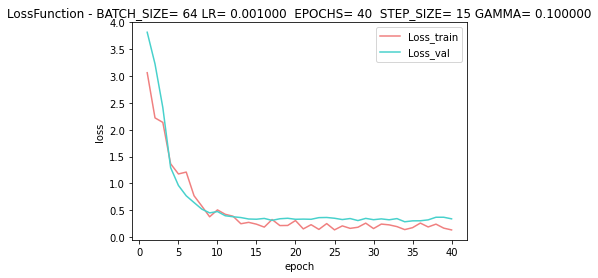

0.9215076071922544


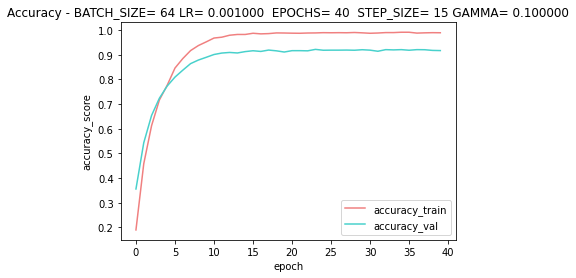

In [23]:
tit = 'LossFunction - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' % (BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
x=np.linspace(1,40,40)
#punti=[1,4,8,12,16,20,24]
plt.plot(x,loss_vector,color='lightcoral')
plt.plot(x,loss_val,color='mediumturquoise')
#plt.xticks(punti)
plt.title(tit)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_train','Loss_val'],loc='upper right')
plt.show()
tit_2='Accuracy - BATCH_SIZE= %d LR= %f  EPOCHS= %d  STEP_SIZE= %d GAMMA= %f' %(BATCH_SIZE, LR, NUM_EPOCHS, STEP_SIZE,GAMMA)
plt.plot(acc_train,color='lightcoral')
plt.plot(tot_accuracy,color='mediumturquoise')
plt.legend(['accuracy_train','accuracy_val'],loc='best')
plt.title(tit_2)
plt.xlabel('epoch')
plt.ylabel('accuracy_score')
#plt.xticks(punti)
#print(acc_train)
print(best_accuracy)

In [24]:
#TEST
net = best_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False)

running_corrects = 0
for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

  0%|          | 0/46 [00:00<?, ?it/s]

2893
2893


100%|██████████| 46/46 [00:06<00:00,  6.73it/s]

2893
Test Accuracy: 0.9125475285171103
